# FCA sn analysis for FEMALES - Supporting reanalysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/clustering_females/supporting/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
idna                2.10
igraph              0.9.1
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.

'/opt/conda/bin/python'

## Load data

In [2]:
adata = sc.read('FCAsn-M3denoised_clusters_female.h5ad')
adata.X.shape

(5102, 29248)

## Filter supporting

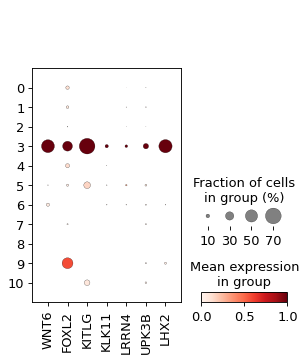

In [3]:
sc.pl.dotplot(adata, ['WNT6', 'FOXL2', 'KITLG', 'KLK11', 'LRRN4', 'UPK3B', 'LHX2'], groupby='leiden', standard_scale='var')

In [4]:
adata = adata[[ i in '3' for i in adata.obs['leiden']]]

In [5]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 458
Total number of genes: 29248


### Reset an reanalize

In [6]:
# Save relevant information
ccgs = adata.uns['ccgs']
# Re-set the object to the raw
adata = anndata.AnnData(X=adata.raw.X,var=adata.raw.var,obs=adata.obs)
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 458
Total number of genes: 29383


## Preprocess the data again

#### Filter non-expressed genes

In [7]:
sc.pp.filter_genes(adata, min_cells=5)
adata.raw = adata.copy()

filtered out 12037 genes that are detected in less than 5 cells


#### CCG, no need to redefine

In [8]:
# adata.uns['ccgs'] = ccgs
# adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]

#### Normalize per cell

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [10]:
sc.pp.log1p(adata)

### Filter HVGs in bdata and do PCA with them

In [11]:
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata, )
for col in ['highly_variable','means', 'dispersions', 'dispersions_norm']:
    adata.var[col] = bdata.var[col]
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Total number of cells: 458
Total number of genes: 4339


In [12]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


## Transfer PCA to the main adata

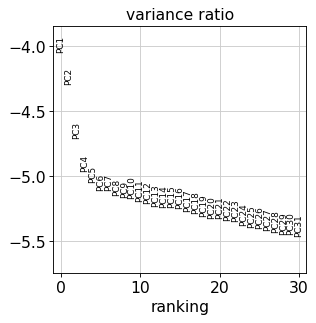

In [13]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

#### Scale and regress out cell cycle genes

In [14]:
# Scale
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### UMAP

In [15]:
n_pcs = 7

In [16]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


## Clustering the graph
As Seurat and many others, we use the leiden graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015).

In [17]:
sc.tl.leiden(adata, resolution=0.3)
# sc.tl.leiden(adata, resolution=0.2)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


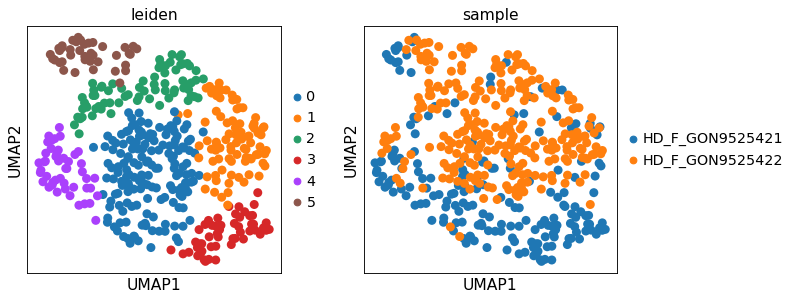

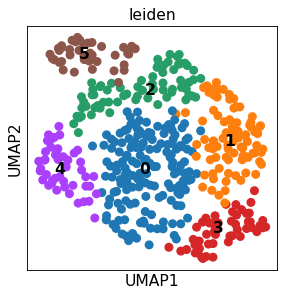

In [18]:
sc.pl.umap(adata, color=['leiden', 'sample'] )
sc.pl.umap(adata, color=['leiden'],legend_loc='on data',save='_clustering_clusnumbers.pdf' )

### Visualize general markers

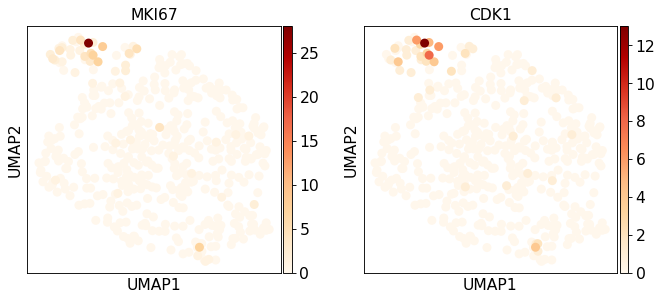

In [19]:
sc.pl.umap(adata, color=['MKI67', 'CDK1'], save='-markers_cycling.pdf',color_map='OrRd', use_raw=True)

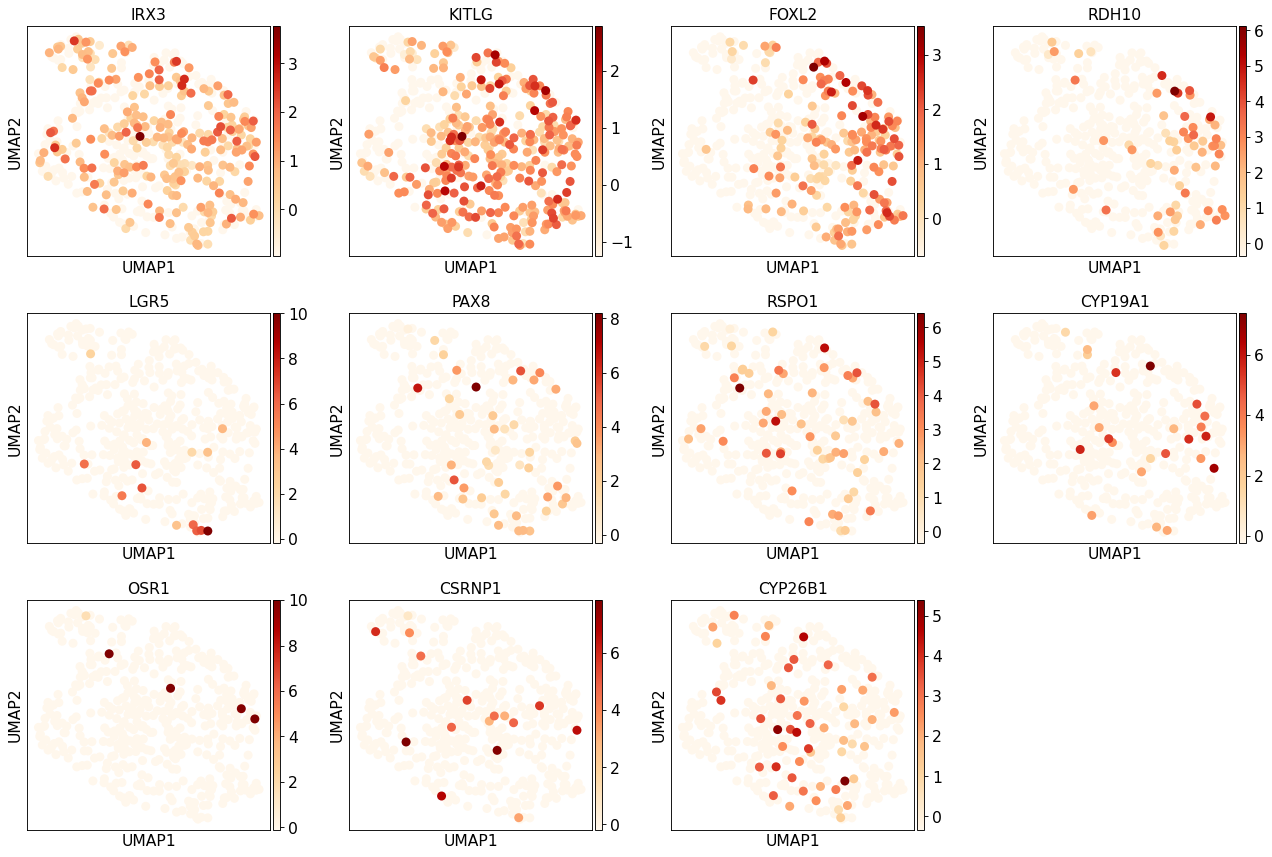

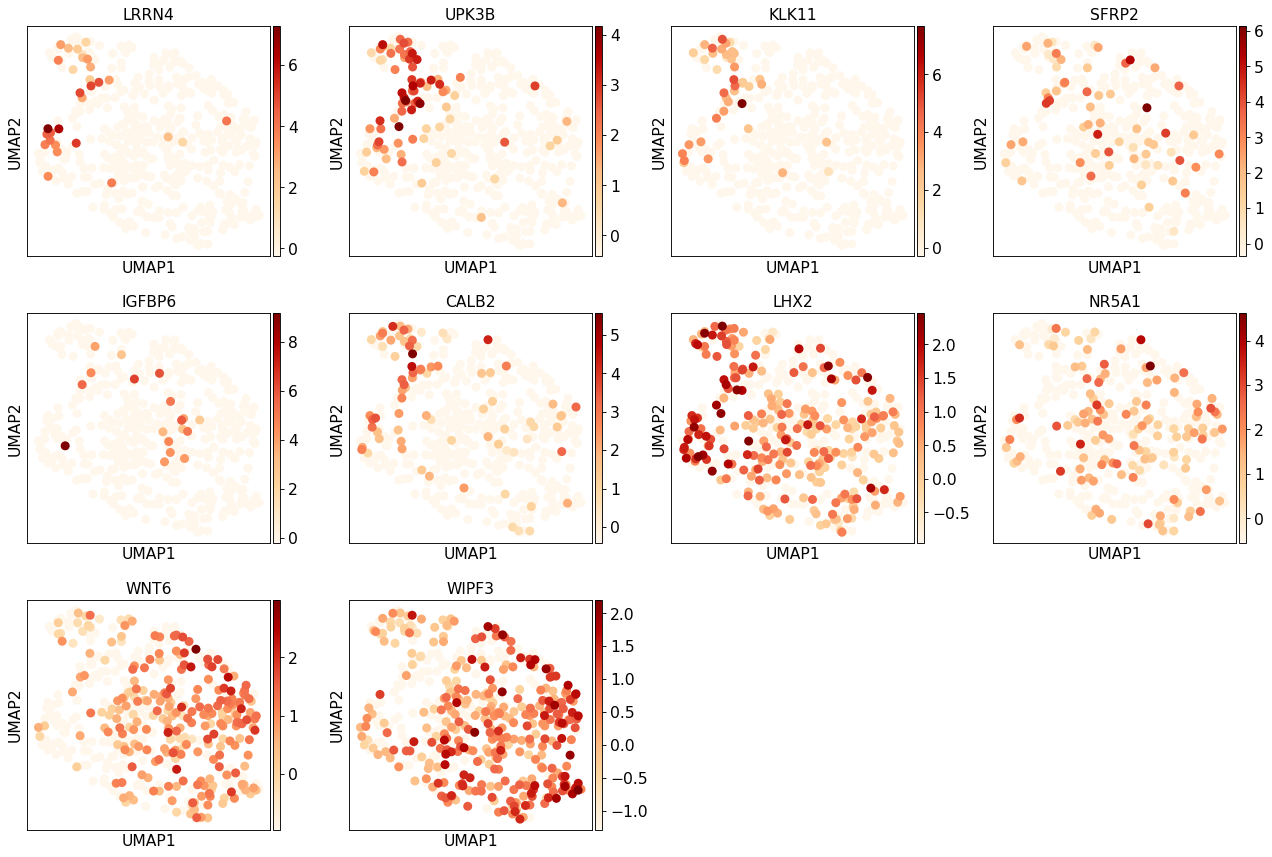

In [20]:
sc.pl.umap(adata, color=['IRX3', "KITLG", 'FOXL2', 'RDH10','LGR5','PAX8', 'RSPO1',  'CYP19A1', 'OSR1', 'CSRNP1', 'CYP26B1'], color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['LRRN4', 'UPK3B', 'KLK11','SFRP2', 'IGFBP6','CALB2', 'LHX2','NR5A1','WNT6', 'WIPF3'], color_map='OrRd', use_raw=False )

### Check global trends

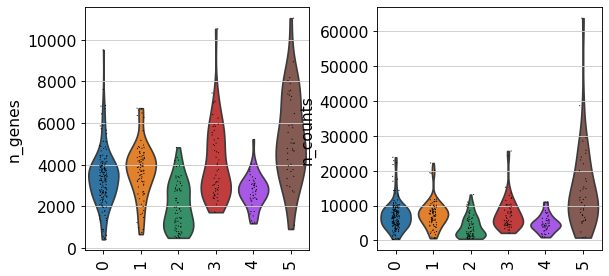

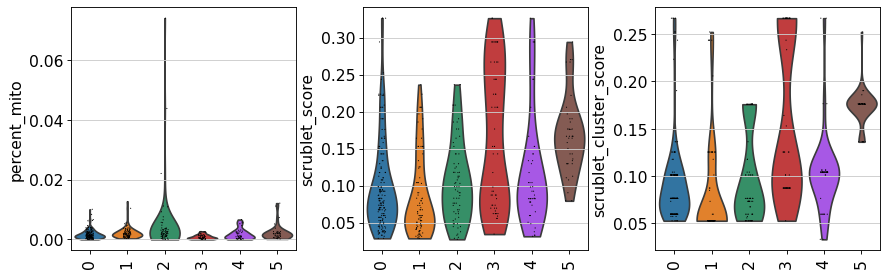

In [21]:
sc.pl.violin(adata, keys= ['n_genes', 'n_counts'], groupby = 'leiden', save='_clusters_statsI.pdf', rotation = 90)
sc.pl.violin(adata, keys= ['percent_mito', 'scrublet_score', 'scrublet_cluster_score'], groupby = 'leiden', save='_clusters_statsII.pdf', rotation = 90)

## Save adata

In [22]:
adata.write('FCAsn-M7supporting_female.h5ad')

# Finding marker genes

Compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

## All vs rest

### TF-IDF based

ranking genes
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


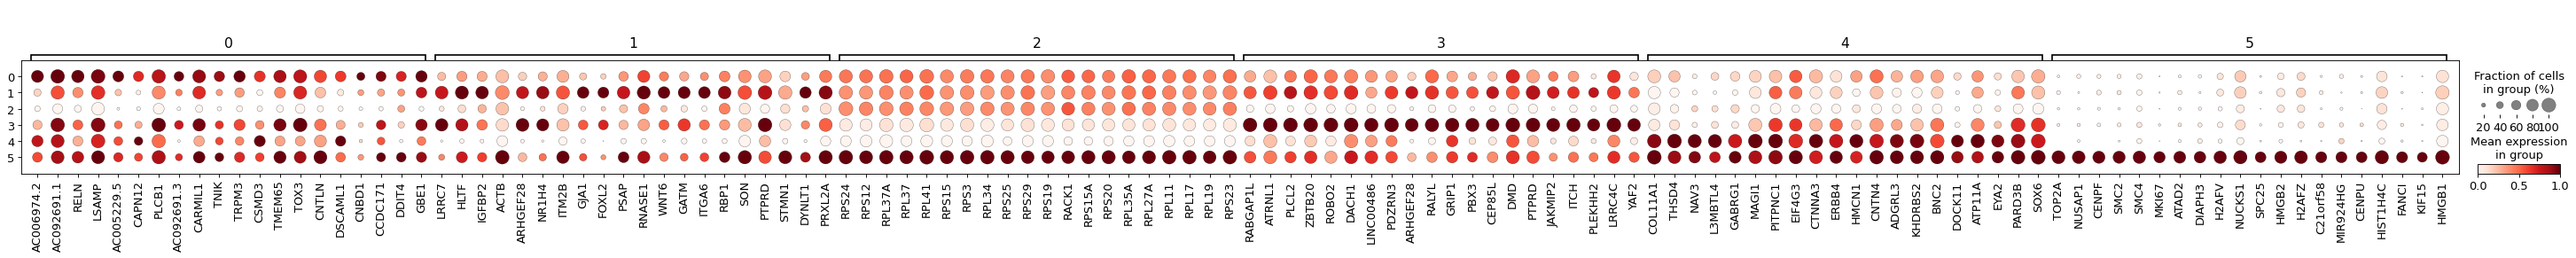

In [23]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata, n_genes=20, dendrogram=False, save='_scanpy.pdf', standard_scale = 'var')

In [24]:
adata_counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)

In [25]:
# Binarize counts matrix (1 if expressed, 0 otherwise)
import episcanpy as epi
adata_bin = epi.pp.binarize(adata_counts, copy=True)
adata_bin.X.shape
# Compute TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(adata_bin.X.T)
adata_bin.X = tfidf.T
adata_bin.X.shape

(458, 17346)

In [26]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata_bin, groupby='leiden', use_raw=False) #, method='logreg'

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


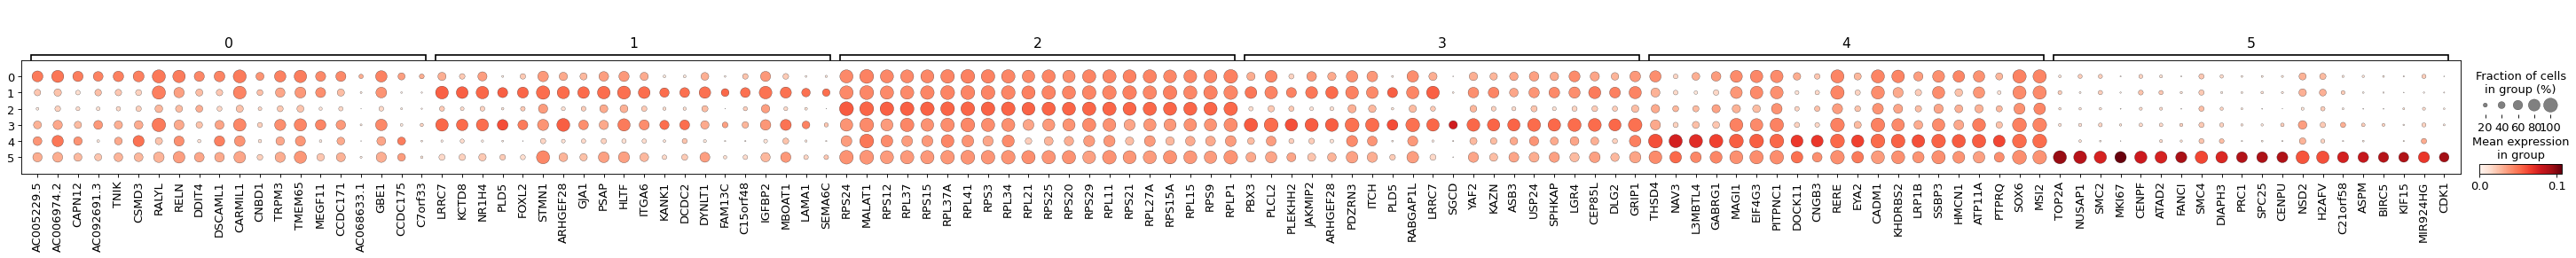

In [27]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False, save='_rawtfidf_scanpy.pdf')

In [28]:
# Plot with gene expression normalized values
sc.pp.normalize_per_cell(adata_counts, counts_per_cell_after=1e4)
sc.pp.log1p(adata_counts)
sc.pp.scale(adata_counts, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


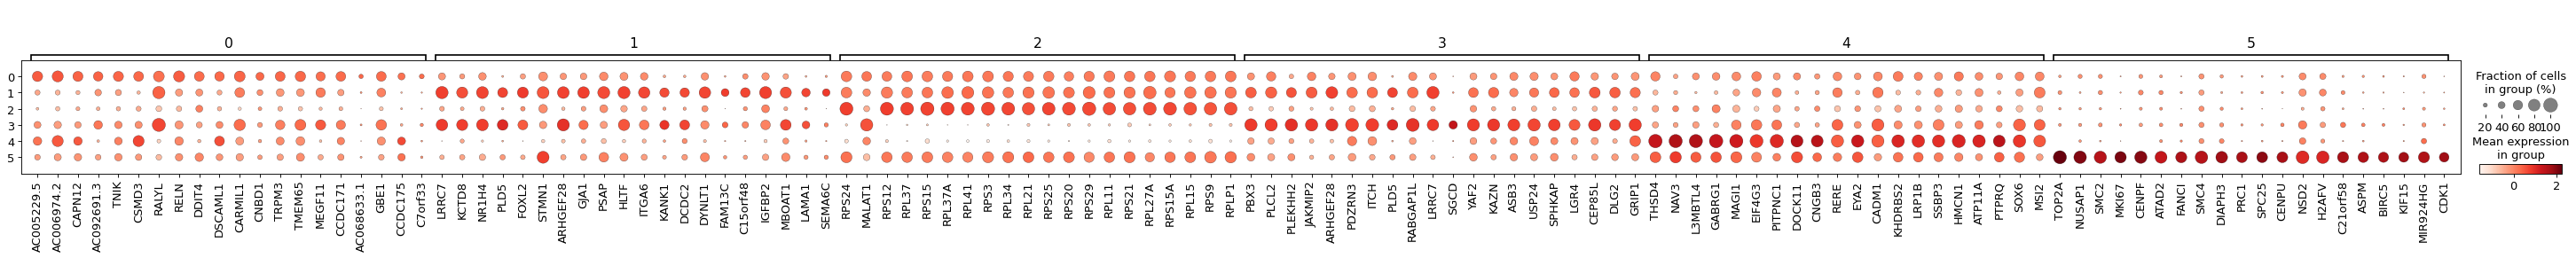

In [29]:
adata_counts.uns['rank_genes_groups'] = adata_bin.uns['rank_genes_groups']
sc.pl.rank_genes_groups_dotplot(adata_counts, n_genes=20, dendrogram=False, save='_tfidf_scanpy.pdf', use_raw = False)

In [30]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

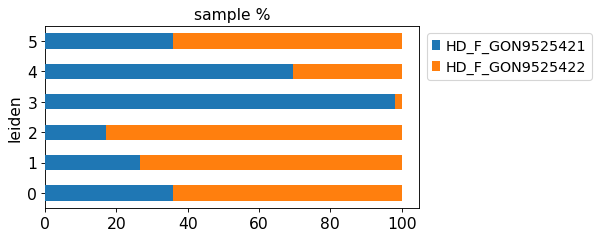

In [31]:
Barplot('sample', adata, var='leiden', height=3)

In [35]:
marker_genes = {
    'mesothelial':{'LRRN4', 'UPK3B', 'KLK11'},
                'coelEpi':{'SFRP2', 'IGFBP6'},
                'OSE':{'CALB2', 'LHX2'},
                'gonad_somatic_cells':{'NR5A1'},
                'supporting_lineage':{'WNT6', 'WIPF3'},
                'sLGR5':{'LGR5',  'GLUD2', 'CCKBR'},
                'sPAX8':{'PAX8', 'SST', 'PLAU',  'NRGN', 'PCP4','CXCL12'},
                'preGranulosa_cor':{'IRX3', "KITLG",  'CSRNP1', 'CYP26B1', 'NDUFA4L2'},
                'preGranulosa_me':{'FOXL2', 'RDH10', 'BMP2', 'CYP19A1', 'OSR1', 'NOTCH3'},
                'cycling':{'CDK1', 'MKI67'}  
}

In [36]:
marker_matches = sc.tl.marker_gene_overlap(adata_bin, marker_genes, method = 'overlap_coef')
marker_matches = marker_matches.set_axis('cl_'+marker_matches.columns, axis=1, inplace=False)

<AxesSubplot:>

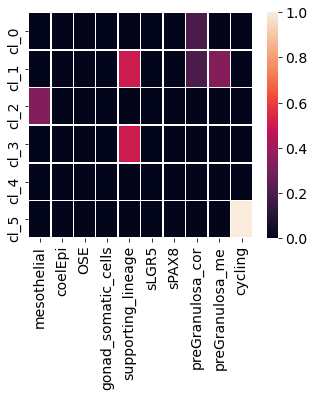

In [37]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,4))  
sns.heatmap(marker_matches.T, annot=False, xticklabels=True, yticklabels=True, linewidths=0.5, ax= ax)

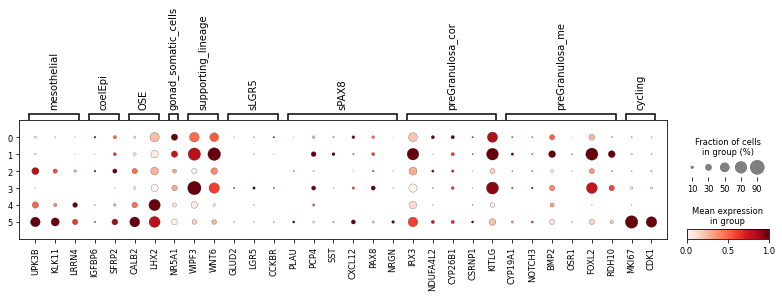

In [38]:
sc.pl.dotplot(adata_counts, marker_genes, groupby='leiden', standard_scale='var')

... storing 'clusters' as categorical


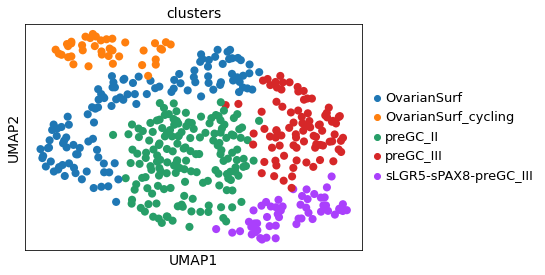

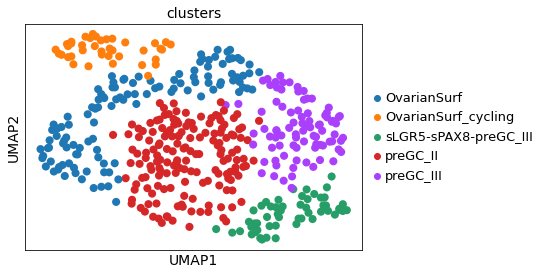

In [40]:
adata.obs['clusters'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['clusters'] == '0', 'clusters'] = 'preGC_II'
adata.obs.at[adata.obs['clusters'] == '1', 'clusters'] = 'preGC_III'
adata.obs.at[adata.obs['clusters'] == '2', 'clusters'] = 'OvarianSurf'
adata.obs.at[adata.obs['clusters'] == '3', 'clusters'] = 'sLGR5-sPAX8-preGC_III'
adata.obs.at[adata.obs['clusters'] == '4', 'clusters'] = 'OvarianSurf'
adata.obs.at[adata.obs['clusters'] == '5', 'clusters'] = 'OvarianSurf_cycling'
set(adata.obs['clusters'])
sc.pl.umap(adata, color=['clusters'])
adata.obs['clusters'].cat.reorder_categories(['OvarianSurf', 'OvarianSurf_cycling', 'sLGR5-sPAX8-preGC_III',
                                              'preGC_II', 'preGC_III'], inplace=True)

sc.pl.umap(adata, color=['clusters'])

In [41]:
pd.DataFrame(adata.obs).to_csv('/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_female_Hrv39_supporting.csv')

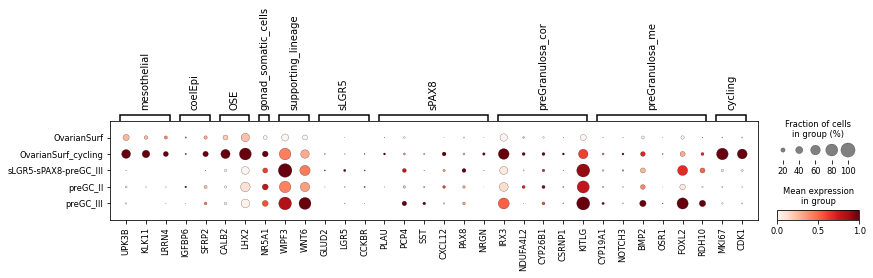

In [42]:
sc.pl.dotplot(adata, marker_genes, groupby='clusters', standard_scale='var')